# Activity detection on static data

In [ ]:
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
import pandas as pd
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
)  # Gives easier dataset managment and creates mini batches


In [119]:
import csv
with open('datapool.csv', 'w', newline='') as file:
    fieldnames = ['Image', 'Label']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(328):
        writer.writerow({'Image': 'sit' + str(i+1) + '.png', 'Label': 0})
    for i in range(230):
        writer.writerow({'Image': 'stand' + str(i+1) + '.png', 'Label': 1})
        

In [121]:
an = pd.read_csv('datapool.csv')
an.head

<bound method NDFrame.head of             Image  Label
0        sit1.png      0
1        sit2.png      0
2        sit3.png      0
3        sit4.png      0
4        sit5.png      0
..            ...    ...
553  stand226.png      1
554  stand227.png      1
555  stand228.png      1
556  stand229.png      1
557  stand230.png      1

[558 rows x 2 columns]>

In [131]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [132]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 32
num_epochs = 10

In [133]:
# Load Data
dataset = CustomImageDataset(
    csv_file="datapool.csv",
    root_dir="datapool",
    transform=transforms.ToTensor(),
)

In [124]:
print(len(dataset))
train_set, test_set = torch.utils.data.random_split(dataset, [390, 168])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)


558


In [103]:
# Model
model = torchvision.models.googlenet(pretrained=True)
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [116]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [126]:
# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")


Cost at epoch 0 is 1.241349098774103
Cost at epoch 1 is 0.23748125823644492
Cost at epoch 2 is 0.13176235284369725
Cost at epoch 3 is 0.07983459281520201
Cost at epoch 4 is 0.03885543108201371
Cost at epoch 5 is 0.08584634612242763
Cost at epoch 6 is 0.07030096241774467
Cost at epoch 7 is 0.05371632340113418
Cost at epoch 8 is 0.05353986002648106
Cost at epoch 9 is 0.0555898763705045


In [127]:
# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()


print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)

Checking accuracy on Training Set
Got 369 / 390 with accuracy 94.62
Checking accuracy on Test Set
Got 147 / 168 with accuracy 87.50


# This is the activity prediction with dynamic data




In [78]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [79]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [80]:
#resize to train data faster and to train data uniformly
image_height, image_width = 64, 64
max_images_per_class = 990

dataset_directory = "dummydata"
classes_list = ["sitting", "standing", "walking", "falling"]

model_output_size = len(classes_list)

In [81]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    for filename in os.listdir(video_path):
        frame = cv2.imread(os.path.join(video_path,filename))
        if frame is not None:
            # Resize the Frame to fixed Dimensions
            resized_frame = cv2.resize(frame, (image_height, image_width))

            # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
            normalized_frame = resized_frame / 255

            # Appending the normalized frame into the frames list
            frames_list.append(normalized_frame)
            
    return frames_list

In [82]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:
            #print(file_name)
            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
            
            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        if(class_name == 'falling'):
            max_images_per_class = 990
        elif(class_name == 'sitting'):
            max_images_per_class = 2050
        elif(class_name == 'walking'):
            max_images_per_class = 1100
        else:
            max_images_per_class = 1100
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [83]:
features, labels = create_dataset()
print(features.shape)
print(labels.shape)

Extracting Data of Class: sitting
Extracting Data of Class: standing
Extracting Data of Class: walking
Extracting Data of Class: falling
(5240, 64, 64, 3)
(5240,)


In [84]:
one_hot_encoded_labels = to_categorical(labels)

In [85]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [86]:
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               16640     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)              

In [64]:
from PIL import Image

image = Image.open('model_structure.png')
image.show()

In [173]:
# Adding the Early Stopping Callback to the model which will continuously monitor the validation loss metric for every epoch.
# If the models validation loss does not decrease after 15 consecutive epochs, the training will be stopped and the weight which reported the lowest validation loss will be retored in the model.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
839/839 [==============================] - 117s 138ms/step - loss: 1.2787 - accuracy: 0.4210 - val_loss: 2.4731 - val_accuracy: 0.3135
Epoch 2/50
839/839 [==============================] - 113s 135ms/step - loss: 1.1696 - accuracy: 0.4518 - val_loss: 2.4348 - val_accuracy: 0.2849
Epoch 3/50
839/839 [==============================] - 88s 105ms/step - loss: 1.1004 - accuracy: 0.5121 - val_loss: 2.2035 - val_accuracy: 0.4517
Epoch 4/50
839/839 [==============================] - 86s 102ms/step - loss: 1.0683 - accuracy: 0.5253 - val_loss: 1.9588 - val_accuracy: 0.4458
Epoch 5/50
839/839 [==============================] - 87s 104ms/step - loss: 1.0428 - accuracy: 0.5483 - val_loss: 1.9074 - val_accuracy: 0.3290
Epoch 6/50
839/839 [==============================] - 82s 98ms/step - loss: 0.9429 - accuracy: 0.6060 - val_loss: 1.9685 - val_accuracy: 0.5602
Epoch 7/50
839/839 [==============================] - 83s 99ms/step - loss: 0.9557 - accuracy: 0.6116 - val_loss: 3.1453 - val_ac

In [107]:
model_evaluation_history = model.evaluate(features_test, labels_test)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [101]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)

In [102]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

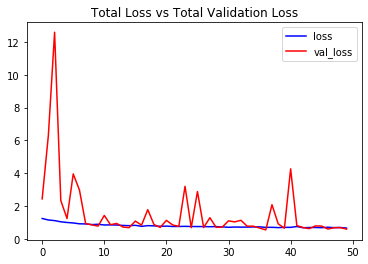

In [103]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

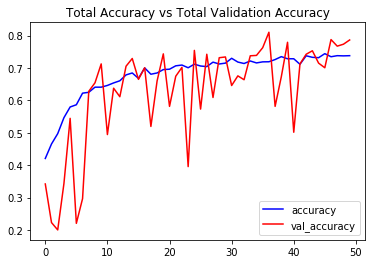

In [104]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [109]:
def load_trained_model(weights_path):
   model = create_model()
   model.load_weights(weights_path)

In [111]:
def predict_on_live_video(video_file_path, output_file_path, window_size):
    
    model = load_trained_model('Model___Date_Time_2021_05_03__13_03_12___Loss_0.5381714701652527___Accuracy_0.8129770755767822.h5')
    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object

    # Getting the width and height of the video 
    original_video_width = 720 #int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = 486 #int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))
    for filename in os.listdir(video_file_path):
        frame = cv2.imread(os.path.join(video_file_path,filename))
        if frame is not None:
        # Resize the Frame to fixed Dimensions
            resized_frame = cv2.resize(frame, (image_height, image_width))

            # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
            normalized_frame = resized_frame / 255

            # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
            predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

            # Appending predicted label probabilities to the deque object
            predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

            # Assuring that the Deque is completely filled before starting the averaging process
            if len(predicted_labels_probabilities_deque) == window_size:

                # Converting Predicted Labels Probabilities Deque into Numpy array
                predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

                # Calculating Average of Predicted Labels Probabilities Column Wise 
                predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

                # Converting the predicted probabilities into labels by returning the index of the maximum value.
                predicted_label = np.argmax(predicted_labels_probabilities_averaged)

                # Accessing The Class Name using predicted label.
                predicted_class_name = classes_list[predicted_label]

                # Overlaying Class Name Text Ontop of the Frame
                cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                print(predicted_class_name)

        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    #video_reader.release()
    video_writer.release()

In [112]:
output_directory = 'Predicted_Videos'
video_title = 'prediction'
input_video_file_path = 'dummydata/falling/fall40'
#input_video_file_path = 'Data4' 
# Setting sthe Widow Size which will be used by the Rolling Averge Proces
window_size = 1

# Construting The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
#VideoFileClip(output_video_file_path).ipython_display(width = 700)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               16640     
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)              

AttributeError: 'NoneType' object has no attribute 'predict'

In [98]:
def make_average_predictions(video_file_path, predictions_frames_count):
    
    # Initializing the Numpy array which will store Prediction Probabilities
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

    frame_counter = 0
    for filename in os.listdir(video_file_path):
        
        frame = cv2.imread(os.path.join(video_file_path,filename))
        
        # Setting Frame Position
        #video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        #_ , frame = video_reader.read()

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities
        frame_counter = frame_counter + 1
    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]

        print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {(predicted_probability*100):.2}")
    
    # Closing the VideoCapture Object and releasing all resources held by it. 
    #video_reader.release()

In [100]:
input_video_file_path = 'Data3' 
#input_video_file_path = 'dummydata/falling/fall40'
# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

CLASS NAME: walking   AVERAGED PROBABILITY: 9.7
CLASS NAME: sitting   AVERAGED PROBABILITY: 9.6
CLASS NAME: standing   AVERAGED PROBABILITY: 9.5
CLASS NAME: falling   AVERAGED PROBABILITY: 9.2


# Activity detection using sound data


# # Module 1 split sound data

In [ ]:
from pydub import AudioSegment
from pydub.utils import make_chunks

input_path = 'soundData\\standing'
count = 0
for filename in os.listdir(input_path):
        #frame = cv2.imread(os.path.join(video_path,filename))

    myaudio = AudioSegment.from_file(os.path.join(input_path,filename) , "wav") 
    chunk_length_ms = 1000 # pydub calculates in millisec
    chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec

    #Export all of the individual chunks as wav files
    count += 1
    #folder_name = 'chunkedData\\falling\\fall' + str(count) + '\\'
    folder_name = 'chunkedData\\standing\\'
    path = os.path.join(folder_name,'stand' + str(count))
    os.mkdir(path)
    for i, chunk in enumerate(chunks):
        chunk_name = "chunk{0}.wav".format(i)
        #print (folder_name+chunk_name)
        chunk.export(os.path.join(path,chunk_name), format="wav")

In [21]:
import librosa
import librosa.display
import IPython.display as idp
import matplotlib.pyplot as plt
import numpy as np


In [29]:
sound_directory = 'chunkedData'
output_directory = 'soundImages'
n_ftt = 2048
hop_length = 512

In [25]:
def create_spectograms(sound_path, output_path):

    count = 0
    for filename in os.listdir(sound_path):
        signal, sr = librosa.load(os.path.join(sound_path,filename))
        #signal, sr = librosa.load(audio_file)
        #MFCCs
        #important features like formant and spectural envolope
        count += 1
        path = os.path.join(output_path, str(count))
        mfcc = librosa.feature.mfcc(signal, n_fft=n_ftt, hop_length=hop_length, n_mfcc=12)
        librosa.display.specshow(mfcc, sr=sr, hop_length=hop_length)
        plt.savefig(path + '.png', bbox_inches='tight')
        

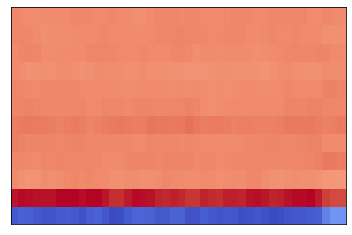

In [26]:
create_spectograms('chunkedData\\sitting\\sit1', 'soundImages\\sitting\\sit1')

Extracting Data of Class: sitting
Extracting Data of Class: standing
Extracting Data of Class: walking
Extracting Data of Class: falling


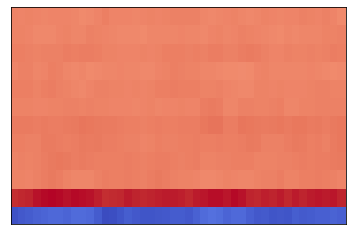

In [34]:
def create_sound_dataset():
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
    #class_name = 'sitting'
        print(f'Extracting Data of Class: {class_name}')

        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(sound_directory, class_name))
        output_list = os.listdir(os.path.join(output_directory, class_name))
        # Iterating through all the files present in the files list
        for file_name in files_list:
            #print(file_name)
            # Construct the complete video path
            sound_file_path = os.path.join(sound_directory, class_name, file_name)
            sound_output_path = os.path.join(output_directory, class_name, file_name)
            os.mkdir(sound_output_path)
            # Calling the frame_extraction method for every video file path
            create_spectograms(sound_file_path, sound_output_path)
create_sound_dataset()

In [51]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(output_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:
            #print(file_name)
            # Construct the complete video path
            video_file_path = os.path.join(output_directory, class_name, file_name)
            
            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        if(class_name == 'falling'):
            max_images_per_class = 200
        elif(class_name == 'sitting'):
            max_images_per_class = 1000
        elif(class_name == 'walking'):
            max_images_per_class = 500
        else:
            max_images_per_class = 500
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [52]:
features, labels = create_dataset()
print(features.shape)
print(labels.shape)

Extracting Data of Class: sitting
Extracting Data of Class: standing
Extracting Data of Class: walking
Extracting Data of Class: falling
(2200, 64, 64, 3)
(2200,)
